# Optimal Weather Derivative Hedge 

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from scipy import stats
import scipy.signal as sig
import statsmodels.api as sm
from scipy.optimize import minimize
import os
import os.path

#taking care of the directories
current_dir = os.getcwd()
parent = os.path.join(current_dir, "..")
normal_parent = os.path.normpath(parent)

In [17]:
Tin = pd.read_pickle(normal_parent+"\\Tout.pkl")

eta = pd.read_pickle(normal_parent+"\\Tinnov.pkl")

Pin = pd.read_pickle(normal_parent+"\\Pout.pkl")

Loss = pd.read_pickle(normal_parent+"\\Loss.pkl")

dV = pd.read_pickle(normal_parent+"\\dV.pkl")

V0 = pd.read_pickle(normal_parent+"\\V0.pkl")

-16482.02146156532

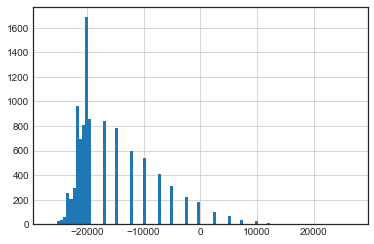

In [18]:
Loss.hist(bins=100);
Loss.mean()

### Too many constraints for daves laptop! See S. Alexander et al 

In [19]:
def rho(z):
    epsilon = 0.1
    if z>= epsilon:
        return z
    elif np.abs(z) < epsilon:
        return z**2/(4*epsilon) + 0.5*z + 0.25*epsilon
    else:
        return 0
    return -1

def Drho(z):
    epsilon = 0.1
    if z>= epsilon:
        return 1
    elif np.abs(z) < epsilon:
        return z/(2*epsilon) + 0.5
    else:
        return 0
    return -1
vrho = np.vectorize(rho)
vDrho = np.vectorize(Drho)

In [20]:
alpha = 1
x = np.random.rand(dV.shape[1]+1)
V0 = np.array(V0)
deltaV = np.array(dV)
Lss = np.array(Loss)
Beta = 0.95
omega = 10**(-3.5)
c = np.maximum(omega*np.percentile(Lss, 100*Beta), (-1)*omega*np.percentile(Lss, 100*Beta))
C = (-1)*Lss.mean()/4;
def F(x):
    return x[0] + (1/(1-Beta))*vrho(Lss - np.inner(deltaV,x[1:])-x[0]).mean() + c*abs(x[1:]).sum()
F(x)
def grad_F(x):
    der = np.zeros_like(x)
    der[0] = 1 - (1/(1-Beta))*vDrho(Lss - np.inner(deltaV,x[1:])-x[0]).mean()
    left = np.expand_dims((1/(1-Beta))*vDrho(Lss - np.inner(deltaV,x[1:])-x[0]),axis=0)
    M = left.size
    der[1:] = -1*(1/M)*np.inner(left,np.transpose(deltaV)) + c
    return der
if c < 0:
    print("penalty parameter is less than zero")
vrho

In [21]:
cons = ({'type': 'ineq',
         'fun' : lambda x: -1*np.inner(V0,x[1:]) + C,
         'jac' : lambda x: -1*np.insert(V0,0,0)},
       {'type': 'ineq',
          'fun' : lambda x: -1*Lss.mean()+1*np.inner(deltaV, x[1:]).mean(),
          'jac' : lambda x: np.insert(1*deltaV.mean(axis = 0),0,0)})
bnds = ((None,None),)
for i in range(dV.shape[1]):
    bnds = bnds + ((0, C),)


In [22]:
res = minimize(F, x , jac=grad_F, bounds = bnds,
               constraints=cons, method='SLSQP', options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1363.3026366531276
            Iterations: 61
            Function evaluations: 153
            Gradient evaluations: 61


In [23]:
dV.shape

(10000, 210)

In [24]:
Lss_opt = Lss - np.inner(deltaV,res.x[1:])
varwithout = np.percentile(Lss, 100*Beta)
varwith = np.percentile(Lss_opt, 100*Beta)
print("Var without:" + str(varwithout))
print("Var with:" + str(varwith))
print("% decrease:" + str(100*(varwith-varwithout)/varwithout))
print("Cost of portfolio:" + str(np.inner(V0,res.x[1:])))
weights = res.x[1:]/(res.x[1:].sum());
pd.DataFrame(dV.columns[weights > 0.05])

Var without:-2435.82671419
Var with:-3001.63993467
% decrease:23.2287960873
Cost of portfolio:4120.50536541


,0
0,"(2017-08-24 00:00:00, 104.0, 1.0, Precip, call)"
1,"(2017-10-15 00:00:00, 104.0, 0.0, HDD, call)"
2,"(2017-10-15 00:00:00, 104.0, 0.0, Precip, call)"
3,"(2017-12-06 00:00:00, 52.0, 0.0, HDD, call)"
4,"(2017-12-06 00:00:00, 104.0, -1.0, HDD, call)"
5,"(2017-12-06 00:00:00, 104.0, 0.0, HDD, call)"
6,"(2018-01-27 00:00:00, 104.0, 0.0, Precip, call)"
7,"(2018-01-27 00:00:00, 104.0, 1.0, Precip, call)"
8,"(2018-05-11 00:00:00, 104.0, 0.0, CDD, call)"


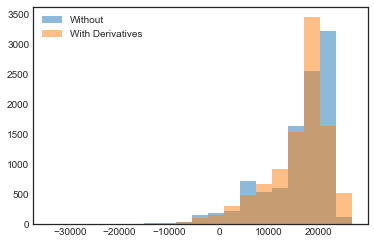

In [25]:
plt.figure
#pd.DataFrame([Lss_opt,Loss],index = ["With Derivatives", "Without"]).transpose().plot.hist();
bins = np.linspace(min(np.minimum(Lss_opt,Loss)), max(np.maximum(Lss_opt,Loss)), 20)
plt.hist(-1*Loss, bins, alpha=0.5, label="Without")
plt.hist(-1*Lss_opt, bins, alpha=0.5, label='With Derivatives')

plt.legend(loc='upper left')
plt.show()


In [26]:
min(np.minimum(Lss_opt,Loss))

-34398.22171372466

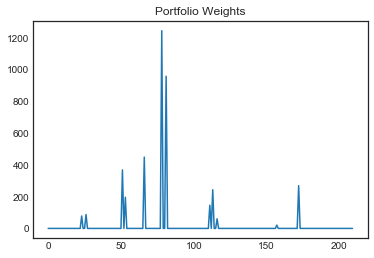

In [27]:
plt.figure
plt.plot(V0*res.x[1:])
plt.title('Portfolio Weights');

In [28]:
schedule = pd.DataFrame(dV.columns[weights > 0.05],columns = ['A'])
schedule.A
schedule = pd.DataFrame([*schedule.A],columns = ['date', 'duration', 'strike (std)', 'index', 'option type'])
schedule['ind'] = schedule['index'].str.cat(schedule['option type'], sep='--')
schedule['ind'] = schedule['ind'].str.cat(schedule['duration'].astype(str), sep='--')
schedule['ind'] = schedule['ind'].str.cat(schedule['strike (std)'].astype(str), sep='--')
schedule['ind'] = schedule['ind'].str.cat(schedule['date'].astype(str), sep='--')
schedule['Start_Date'] = pd.to_datetime(schedule['date']).astype(dt.datetime)
schedule ['End_Date'] = pd.to_datetime(schedule['date']+pd.to_timedelta(schedule['duration'], unit = 'd')).astype(dt.datetime)

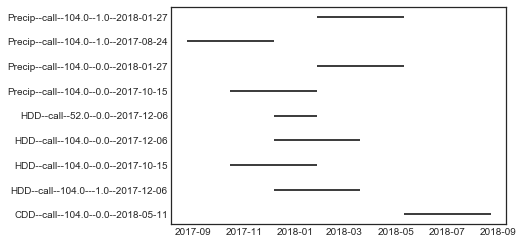

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as dt
fig = plt.figure()
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(schedule['ind'], dt.date2num(schedule['Start_Date']), dt.date2num(schedule ['End_Date']))